In [2]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
# manipulacion de datos
import pandas as pd
import numpy as np

# modelos estadisticos
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
#from statsmodels.stats.multicomp import pairwise_scheffe
import statsmodels.stats.multicomp 
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sa
import statsmodels.formula.api as smf

In [4]:
import researchpy as rp

In [5]:
from scipy.stats import f_oneway

In [34]:
import scikit_posthocs as sp

In [7]:
from scipy import stats

# Importación de los datos

In [8]:
archivo = 'Ejemplo1.xlsx'

In [9]:
df = pd.read_excel(archivo)

## Se transformar las variables 'tratamiento' y 'bloque' a categorica

In [10]:
df['tratamiento'] = df['tratamiento'].astype(object)
df['bloque'] = df['bloque'].astype(object)


## Construccion del modelo de regresión

In [24]:
mod = smf.ols('produccion ~ tratamiento + bloque', data = df).fit()
mod

### Anova de la regresión

In [12]:
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:             produccion   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     18.45
Date:                Fri, 01 Apr 2022   Prob (F-statistic):           1.89e-06
Time:                        23:49:21   Log-Likelihood:                -41.761
No. Observations:                  24   AIC:                             101.5
Df Residuals:                      15   BIC:                             112.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           32.2417      1.068  

### El ANOVA anterior nos da detalles de cada tratamiento y bloques, sin embargo, es necesario comprobar la significancia estadística de los tratamientos y los bloques para comprobar si es necesario bloquear es experimento. A continuación se presenta el ANOVA de la regresión con evaluando tratamientos y bloques en conjunto y no discriminados.

In [13]:
anova = sa.stats.anova_lm(mod)
print(anova)

               df      sum_sq    mean_sq          F    PR(>F)
tratamiento   5.0  256.153333  51.230667  16.846036  0.000011
bloque        3.0  192.748333  64.249444  21.126964  0.000012
Residual     15.0   45.616667   3.041111        NaN       NaN


### De acuerdo con los resultados obtenidos en el ANOVA, se evidencia que los tratamientos y los bloques presentan impacto significativos en los efectos del experimiento, por lo tanto, se confirma la necesidad de bloquear y qué las medias de los tratamientos no son iguales.

## Comprobación de los supuestos del error del experimento (El error tiene distribución normal con media 0 y varianza sigma

## Se comprueba normalidad, esperanza y homocedasticidad

In [14]:
#Calculo de residuos del modelo

predichos = mod.predict()
predichos
residuos = df['produccion'] - predichos
#residuos

In [15]:
# Prueba de normalidad de Shapiro Wilk

shapiro_test = stats.shapiro(residuos)
shapiro_test

ShapiroResult(statistic=0.9673140645027161, pvalue=0.6013219356536865)

In [16]:
# Levene test de homocedasticidad

levene_test = stats.levene(residuos, df['tratamiento'], center='median')
levene_test

LeveneResult(statistic=2.6460413817672066, pvalue=0.11064004396863429)

In [17]:
# Bartlett test de Homocedasticidad

bartlett_test = stats.bartlett(residuos, df['tratamiento'])
bartlett_test

BartlettResult(statistic=1.0241775934938384, pvalue=0.31153011768373795)

In [18]:
# Esperanza del error = 0

np.mean(residuos)

-3.7451523364021945e-14

## Dado que se confirman los supuestos estadísticos del modelo, se procede a encontrar los tratamientos cuyas medias son diferentes

<AxesSubplot:xlabel='bloque', ylabel='produccion'>

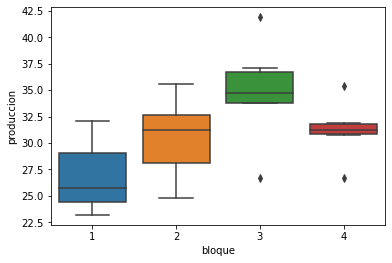

In [19]:
#Grafico de caja y bigotes

sns.boxplot(y = df['produccion'], x = df['bloque'], data = df)

## Las pruebas posthoc de Scheffe y TukeyHSD permiten encontrar diferencias entre las medias de los tratamientos haciendo una comparación multiple entre los pares de estos.

## Ambas pruebas muestran los mismos resultados, pero se realizan ambas para probar los resultados.

In [26]:
#Prueba de Scheffe para comprobar la diferencia entre los tratamientos

sp.posthoc_scheffe(df, val_col = 'produccion', group_col = 'tratamiento')

,1,2,3,4,5,6
1,1.000000,0.805267,0.258459,0.548354,0.484483,0.019942
2,0.805267,1.000000,0.920059,0.997732,0.993756,0.241848
3,0.258459,0.920059,1.000000,0.993756,0.997732,0.784190
4,0.548354,0.997732,0.993756,1.000000,0.999998,0.460546
5,0.484483,0.993756,0.997732,0.999998,1.000000,0.523566
6,0.019942,0.241848,0.784190,0.460546,0.523566,1.000000


In [131]:
f_oneway(df['produccion'], df['bloque'], df['tratamiento'])

F_onewayResult(statistic=720.4175452957713, pvalue=5.850936327490669e-47)

In [23]:
# Prueba de Tukey

tukey = pairwise_tukeyhsd(endog=df['produccion'],
                          groups=df['tratamiento'],
                          alpha=0.05)

#display results
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   -3.875 0.6651 -12.0527  4.3027  False
     1      3     -6.9  0.128 -15.0777  1.2777  False
     1      4   -5.225 0.3642 -13.4027  2.9527  False
     1      5    -5.55  0.304 -13.7277  2.6277  False
     1      6    -10.9 0.0056 -19.0777 -2.7223   True
     2      3   -3.025 0.8425 -11.2027  5.1527  False
     2      4    -1.35 0.9944  -9.5277  6.8277  False
     2      5   -1.675 0.9851  -9.8527  6.5027  False
     2      6   -7.025 0.1172 -15.2027  1.1527  False
     3      4    1.675 0.9851  -6.5027  9.8527  False
     3      5     1.35 0.9944  -6.8277  9.5277  False
     3      6     -4.0 0.6361 -12.1777  4.1777  False
     4      5   -0.325    1.0  -8.5027  7.8527  False
     4      6   -5.675 0.2826 -13.8527  2.5027  False
     5      6    -5.35 0.3402 -13.5277  2.8277  False
----------------------------

## Dado los resultados obtenidos en las pruebas posthoc podemos concluir que los tratamientos, 1 y 6 son diferentes entre sí.